In [ ]:
from pathlib import Path
from statistics import correlation
from typing import Dict, List, Optional, Tuple, Union
import re
import numpy as np
from sympy import false


from RDiff_map_for_arseney_group import get_diffusion_embedding ,affinity_mat
from correlation_calculation_NOGA import corrcoef_safe
import csv
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from diffution_map_functions import (plot_session1_scree,plot_session2_scree,elbow_max_distance,elbow_flat_slope,_regularize_matrix_spd,build_stacked_array_and_index,report_nan_inf_in_subjects,
                                     save_subject_map_to_csv,report_missing_row_names_before_load,build_missing_rows_aggregation,write_missing_rows_csv,
                                     load_tsv_folder_as_subject_dict,save_diffusion_output_with_labels)

In [11]:
# FOLDER = r"data/SCHAEFER_mat_cor"  # e.g. r"C:\data\tsv" or "/home/user/data"
FOLDER = r"data/YEO_mat_cor/YEO_mat_cor"  # e.g. r"C:\data\tsv" or "/home/user/data"
PATTERN = "*.tsv"  # which files to include
DTYPE: Union[type, str] = float  # float | int | 'U' (strings) | etc.
ENCODING = "utf-8"
HAS_HEADER: Optional[bool] = None  # True / False / None for auto-detect

# ignore first row/column after loading
IGNORE_FIRST_ROW = True
IGNORE_FIRST_COL = True
# --- NEW: CSV with row names to remove (first column = row_name) ---
MISSING_ROWS_CSV = Path("data/YEO_mat_cor/csv_out/missing_rows_by_subject.csv")
STACK_ORDER = "key"
Key = Tuple[str, int, int]  # ('NT', 137, 1) לדוגמה
OUT_SUBFOLDER = "csv_out"

In [12]:
pre_missing_rows = report_missing_row_names_before_load(FOLDER, PATTERN, ENCODING)
agg = build_missing_rows_aggregation(FOLDER, PATTERN, ENCODING)

# כתיבת קובץ סיכום ל-CSV
report_csv = Path(FOLDER) / OUT_SUBFOLDER / "missing_rows_by_subject.csv"
write_missing_rows_csv(agg, report_csv)
print(f"\nWrote per-row missing report to: {report_csv.resolve()}")

subject_arrays = load_tsv_folder_as_subject_dict(
    FOLDER, PATTERN, DTYPE, ENCODING, HAS_HEADER,
    drop_first_row=IGNORE_FIRST_ROW,
    drop_first_col=IGNORE_FIRST_COL,MISSING_ROWS_CSV = MISSING_ROWS_CSV)


print(f"\nLoaded {len(subject_arrays)} (group, subject, session) entries from TSV files.\n")



=== Fully-missing row NAMES per file (pre-load) ===
  - ('NT', 15, 3) from NT_sub-015_ses-3_task-rest_space-MNI152NLin2009cAsym_seg-YEO2011_stat-pearsoncorrelation_relmat.tsv: 1 rows -> ['Limbic Network']

Wrote per-row missing report to: C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\missing_rows_by_subject.csv

Loaded 155 (group, subject, session) entries from TSV files.



In [13]:
TARGET_SESSION = 1

filtered_subject_arrays: Dict[Key, Union[np.ndarray, List[np.ndarray]]] = {}

for key, val in subject_arrays.items():
    _, _, session = key
    if session == TARGET_SESSION:
        filtered_subject_arrays[key] = val

print(f"Filtered to include only Session {TARGET_SESSION}. Retained {len(filtered_subject_arrays)} entries.")
subject_arrays = filtered_subject_arrays  # החלפה במילון המסונן

# וידוא שהמטריצות עדיין ריבועיות ושוות בגודל
shapes = {k: v.shape for k, v in subject_arrays.items() if not isinstance(v, list)}
unique_shapes = set(shapes.values())
print("Unique shapes after filtering and removal:", unique_shapes)

Filtered to include only Session 1. Retained 113 entries.
Unique shapes after filtering and removal: {(7, 7)}


In [14]:
# ===== NEW: בנייה של המערך המאוחד + מילון אינדקסים =====
all_arrays, index_by_key, keys_for_index = build_stacked_array_and_index(
    subject_arrays, order=STACK_ORDER
)

print(f"\n array shape: {all_arrays.shape}, dtype={all_arrays.dtype}")
print(f"Index map entries: {len(index_by_key)} (keys) / {len(keys_for_index)} (indices)")
# דוגמה: מציאת האינדקס של נבדק מסוים ושליפה
example_key = ('NT', 137, 1)
if example_key in index_by_key:
    idx = index_by_key[example_key]
    if isinstance(idx, list):
        idx = idx[0]
    print(f"Example {example_key} -> index {idx}, slice shape={all_arrays[idx].shape}")
else:
    print(f"Example key {example_key} not found in index map (likely filtered out).")

window_length = all_arrays.shape[-1]


 array shape: (113, 7, 7), dtype=float64
Index map entries: 113 (keys) / 113 (indices)
Example ('NT', 137, 1) -> index 110, slice shape=(7, 7)


In [15]:

correlations = all_arrays
array_len_ses1 = len(correlations)
print(array_len_ses1)

113


In [16]:

# Scan for NaNs/Infs and report
nan_inf_report = report_nan_inf_in_subjects(subject_arrays)

# The result P_affinity is the row-normalized affinity matrix (110x110 Tensor)
# ready for use in subsequent spectral analysis (like the diffusion map).
# # ===== שלב 2: ניתוח הדיפוזיה - (UNCOMMENTED) =====
# הפונקציה get_diffusion_embedding חייבת להיות זמינה (מהקובץ RDiff_map_for_arseney_group)
diffusion_map, distances ,eigen_values_ses1 = get_diffusion_embedding(
    correlations, array_len_ses1, scale_k=5, signal=None, subsampling=0, mode='riemannian'
)
print(eigen_values_ses1)


=== NaN/Inf scan over subject arrays ===
No NaNs or Infs found in any subject arrays.


Computing distances: 100%|██████████| 6328/6328 [00:01<00:00, 4381.55it/s]

sigma_i = [[1.78446617]
 [1.79983292]
 [1.86927619]
 [1.87372298]
 [1.75556369]
 [1.87358962]
 [1.7502965 ]
 [1.63272631]
 [1.91618145]
 [2.44266262]
 [1.60820903]
 [1.8270554 ]
 [1.8515162 ]
 [1.53232869]
 [1.81309461]
 [1.92074642]
 [1.86927619]
 [1.83232326]
 [1.87726248]
 [1.8828061 ]
 [1.86055311]
 [1.67109612]
 [1.93140694]
 [1.65623411]
 [1.62373299]
 [1.77225479]
 [1.59726315]
 [1.76325253]
 [1.68035643]
 [2.06935779]
 [1.79153992]
 [1.87372298]
 [1.83243107]
 [1.8117318 ]
 [1.77844463]
 [2.02855452]
 [1.74803699]
 [2.43492884]
 [1.78796198]
 [1.87372298]
 [1.60820903]
 [2.10435181]
 [1.71610632]
 [2.2633645 ]
 [2.14030421]
 [1.60820903]
 [1.92440981]
 [1.82803152]
 [1.91467932]
 [1.80322043]
 [1.840063  ]
 [2.13438041]
 [1.58459431]
 [1.62698974]
 [1.57893006]
 [1.96304546]
 [2.37225963]
 [1.80753852]
 [1.59726315]
 [1.5729304 ]
 [1.95366907]
 [1.74051825]
 [1.5729304 ]
 [1.86961539]
 [1.77836149]
 [2.09153763]
 [1.82370228]
 [2.01299177]
 [2.39601671]
 [1.72283237]
 [1.717512


Saved Labeled Diffusion Map CSV to:
  - C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\diffusion_map_ses1_labeled_YEO.csv
Saved Labeled Diffusion Distances CSV to:
  - C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\diffusion_distances_ses1_labeled_YEO.csv


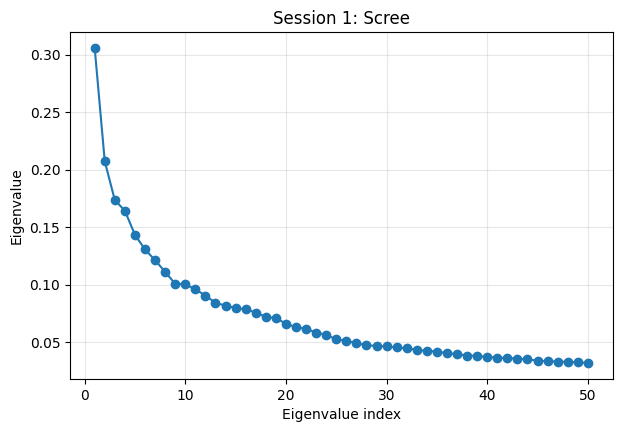

In [17]:
# ===== שלב 3: שמירת פלט הדיפוזיה עם תוויות (Labels) - (UNCOMMENTED) =====
out_dir = Path(FOLDER) / OUT_SUBFOLDER

# 1. שמירת מפת הדיפוזיה (הוספת DC1, DC2,... ככותרות)
dm_csv_path = out_dir / f"diffusion_map_ses{TARGET_SESSION}_labeled_YEO.csv"
dm_csv_path = save_diffusion_output_with_labels(
    diffusion_map,
    keys_for_index,
    is_distance_matrix=False,
    base_path=dm_csv_path,
    encoding=ENCODING
)

# 2. שמירת מטריצת המרחקים (הוספת שמות נבדקים ככותרות שורה ועמודה)
dist_csv_path = out_dir / f"diffusion_distances_ses{TARGET_SESSION}_labeled_YEO.csv"
dist_csv_path = save_diffusion_output_with_labels(
    distances,
    keys_for_index,
    is_distance_matrix=True,
    base_path=dist_csv_path,
    encoding=ENCODING
)

print("\nSaved Labeled Diffusion Map CSV to:")
print("  -", dm_csv_path.resolve())
print("Saved Labeled Diffusion Distances CSV to:")
print("  -", dist_csv_path.resolve())
plot_session1_scree(eigen_values_ses1,k=50, save_path="figures/session1_scree.png")

In [18]:
pre_missing_rows = report_missing_row_names_before_load(FOLDER, PATTERN, ENCODING)
# אגרגציה: עבור כל שם שורה – באילו נבדקים היא all-NaN
agg = build_missing_rows_aggregation(FOLDER, PATTERN, ENCODING)

# כתיבת קובץ סיכום ל-CSV
report_csv = Path(FOLDER) / OUT_SUBFOLDER / "missing_rows_by_subject.csv"
write_missing_rows_csv(agg, report_csv)
print(f"\nWrote per-row missing report to: {report_csv.resolve()}")

subject_arrays = load_tsv_folder_as_subject_dict(
    FOLDER, PATTERN, DTYPE, ENCODING, HAS_HEADER,
    drop_first_row=IGNORE_FIRST_ROW,
    drop_first_col=IGNORE_FIRST_COL,MISSING_ROWS_CSV = MISSING_ROWS_CSV
)

print(f"\nLoaded {len(subject_arrays)} (group, subject, session) entries from TSV files.\n")



=== Fully-missing row NAMES per file (pre-load) ===
  - ('NT', 15, 3) from NT_sub-015_ses-3_task-rest_space-MNI152NLin2009cAsym_seg-YEO2011_stat-pearsoncorrelation_relmat.tsv: 1 rows -> ['Limbic Network']

Wrote per-row missing report to: C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\missing_rows_by_subject.csv

Loaded 155 (group, subject, session) entries from TSV files.



In [19]:

TARGET_SESSION = 2
filtered_subject_arrays: Dict[Key, Union[np.ndarray, List[np.ndarray]]] = {}

for key, val in subject_arrays.items():
    _, _, session = key
    if session == TARGET_SESSION:
        filtered_subject_arrays[key] = val

print(f"Filtered to include only Session {TARGET_SESSION}. Retained {len(filtered_subject_arrays)} entries.")
subject_arrays = filtered_subject_arrays  # החלפה במילון המסונן

# וידוא שהמטריצות עדיין ריבועיות ושוות בגודל
shapes = {k: v.shape for k, v in subject_arrays.items() if not isinstance(v, list)}
unique_shapes = set(shapes.values())
print("Unique shapes after filtering and removal:", unique_shapes)


Filtered to include only Session 2. Retained 39 entries.
Unique shapes after filtering and removal: {(7, 7)}


In [20]:
# הדפסה קצרה
count = 0
for (grp, num, ses), val in subject_arrays.items():
    if isinstance(val, list):
        shp = [v.shape for v in val]
        dt = [v.dtype for v in val]
        print(f"  - ({grp}, {num}, ses={ses}) -> {len(val)} arrays, shapes={shp}, dtypes={dt}")
    else:
        print(f"  - ({grp}, {num}, ses={ses}) -> shape={val.shape} dtype={val.dtype}")
    count += 1
    if count >= 10:
        print("  ... (showing first 10)")
        break

# Save each subject array to CSVs (like before)
out_dir = Path(FOLDER) / OUT_SUBFOLDER
out_dir = save_subject_map_to_csv(subject_arrays, out_dir, ENCODING)
print(f"\nSaved subject CSVs to: {out_dir.resolve()}\n")

  - (CT, 3, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 7, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 10, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 12, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 13, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 18, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 27, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 29, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 32, ses=2) -> shape=(7, 7) dtype=float64
  - (CT, 39, ses=2) -> shape=(7, 7) dtype=float64
  ... (showing first 10)

Saved subject CSVs to: C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out



In [21]:
# ===== NEW: בנייה של המערך המאוחד + מילון אינדקסים =====
all_arrays, index_by_key, keys_for_index = build_stacked_array_and_index(
    subject_arrays, order=STACK_ORDER
)

print(f"\nStacked array shape: {all_arrays.shape}, dtype={all_arrays.dtype}")
print(f"Index map entries: {len(index_by_key)} (keys) / {len(keys_for_index)} (indices)")
# דוגמה: מציאת האינדקס של נבדק מסוים ושליפה



Stacked array shape: (39, 7, 7), dtype=float64
Index map entries: 39 (keys) / 39 (indices)


In [22]:
correlations_ses2 = all_arrays
array_len_ses2  = len(correlations)

In [23]:

# Scan for NaNs/Infs and report
nan_inf_report = report_nan_inf_in_subjects(subject_arrays)

# # ===== שלב 2: ניתוח הדיפוזיה - (UNCOMMENTED) =====
# הפונקציה get_diffusion_embedding חייבת להיות זמינה (מהקובץ RDiff_map_for_arseney_group)
diffusion_map_ses2, distances_ses2, eigen_values_ses2 = get_diffusion_embedding(
    correlations_ses2, array_len_ses2, scale_k=5, signal=None, subsampling=0, mode='riemannian'
)


=== NaN/Inf scan over subject arrays ===
No NaNs or Infs found in any subject arrays.


Computing distances: 100%|██████████| 741/741 [00:00<00:00, 4338.43it/s]

sigma_i = [[2.63117445]
 [2.32795279]
 [2.28919768]
 [2.02366733]
 [2.40330874]
 [1.7751233 ]
 [2.17450053]
 [2.15320592]
 [2.11705841]
 [1.99817601]
 [2.12443601]
 [2.42790353]
 [1.89750711]
 [2.01341491]
 [2.19331169]
 [2.25382965]
 [2.50087292]
 [2.3457987 ]
 [2.72408185]
 [2.13980737]
 [2.50070951]
 [1.99394659]
 [2.5746639 ]
 [2.15593994]
 [2.27271623]
 [1.860026  ]
 [2.06105793]
 [2.08219   ]
 [2.0060558 ]
 [2.18862326]
 [2.00630517]
 [2.42634807]
 [3.04899655]
 [2.02366733]
 [2.02198347]
 [2.55179089]
 [1.90183703]
 [2.04017499]
 [2.15130832]]
/nsigma_j = [[2.63117445 2.32795279 2.28919768 2.02366733 2.40330874 1.7751233
  2.17450053 2.15320592 2.11705841 1.99817601 2.12443601 2.42790353
  1.89750711 2.01341491 2.19331169 2.25382965 2.50087292 2.3457987
  2.72408185 2.13980737 2.50070951 1.99394659 2.5746639  2.15593994
  2.27271623 1.860026   2.06105793 2.08219    2.0060558  2.18862326
  2.00630517 2.42634807 3.04899655 2.02366733 2.02198347 2.55179089
  1.90183703 2.04017499 2

In [24]:
# ===== שלב 3: שמירת פלט הדיפוזיה עם תוויות (Labels) - (UNCOMMENTED) =====
out_dir = Path(FOLDER) / OUT_SUBFOLDER

# 1. שמירת מפת הדיפוזיה (הוספת DC1, DC2,... ככותרות)
dm_csv_path = out_dir / f"diffusion_map_ses{TARGET_SESSION}_labeled_YEO.csv"
dm_csv_path = save_diffusion_output_with_labels(
    diffusion_map_ses2,
    keys_for_index,
    is_distance_matrix=False,
    base_path=dm_csv_path,
    encoding=ENCODING
)

# 2. שמירת מטריצת המרחקים (הוספת שמות נבדקים ככותרות שורה ועמודה)
dist_csv_path = out_dir / f"diffusion_distances_ses{TARGET_SESSION}_labeled_YEO.csv"
dist_csv_path = save_diffusion_output_with_labels(
    distances_ses2,
    keys_for_index,
    is_distance_matrix=True,
    base_path=dist_csv_path,
    encoding=ENCODING
)

print(eigen_values_ses2)

[[0.18338039]
 [0.15917917]
 [0.13612127]
 [0.1197977 ]
 [0.10597967]
 [0.10526177]
 [0.08945171]
 [0.08386634]
 [0.07881995]
 [0.07155299]
 [0.0632624 ]
 [0.05976059]
 [0.05524018]
 [0.05392851]
 [0.05355528]
 [0.0516373 ]
 [0.04613956]
 [0.04477726]
 [0.04023014]
 [0.03894504]
 [0.03762789]
 [0.03577885]
 [0.03392489]
 [0.03106851]
 [0.02842481]
 [0.02794875]
 [0.02625678]
 [0.02473623]
 [0.02329798]
 [0.02223295]
 [0.02112792]
 [0.02058159]
 [0.01930607]
 [0.01880234]
 [0.01670161]
 [0.01576862]
 [0.01470508]
 [0.01372688]]



Saved Labeled Diffusion Map CSV to:
  - C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\diffusion_map_ses2_labeled_YEO.csv
Saved Labeled Diffusion Distances CSV to:
  - C:\Users\nogag\PycharmProjects\technion\data\YEO_mat_cor\YEO_mat_cor\csv_out\diffusion_distances_ses2_labeled_YEO.csv


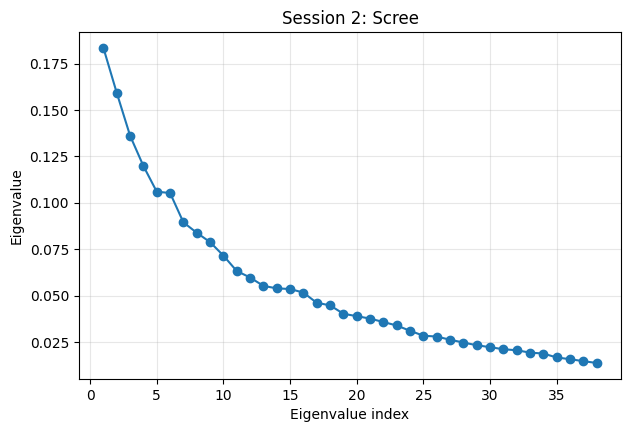

Session 1 — max-distance: k=13, eig≈0.0842488; flat-slope: k=15, eig≈0.0797159
Session 2 — max-distance: k=11, eig≈0.0632624; flat-slope: k=14, eig≈0.0539285


In [25]:
print("\nSaved Labeled Diffusion Map CSV to:")
print("  -", dm_csv_path.resolve())
print("Saved Labeled Diffusion Distances CSV to:")
print("  -", dist_csv_path.resolve())

plot_session2_scree(eigen_values_ses2, save_path="figures/session2_scree.png")

k1_md, val1_md = elbow_max_distance(eigen_values_ses1)
k1_fs, val1_fs = elbow_flat_slope(eigen_values_ses1, window=5, rel_slope=0.10)

k2_md, val2_md = elbow_max_distance(eigen_values_ses2)
k2_fs, val2_fs = elbow_flat_slope(eigen_values_ses2, window=2, rel_slope=0.10)

print(f"Session 1 — max-distance: k={k1_md}, eig≈{val1_md:.6g}; flat-slope: k={k1_fs}, eig≈{val1_fs:.6g}")
print(f"Session 2 — max-distance: k={k2_md}, eig≈{val2_md:.6g}; flat-slope: k={k2_fs}, eig≈{val2_fs:.6g}")
